Loaded CSV. Shape: (500, 6)
Columns: ['Drug Dosage (mg)', 'Systolic Blood Pressure (mmHg)', 'Heart Rate (BPM)', 'Liver Toxicity Index (U/L)', 'Blood Glucose Level (mg/dL)', 'Drug Response']
Auto-selected target column: 'Drug Response' (reason: binary_0_1)

Target value counts (before conversion):
Drug Response
1    260
0    240
Name: count, dtype: int64

Post-processed target value counts:
Drug Response
1    260
0    240
Name: count, dtype: int64

Features shape: (500, 5) Target shape: (500,)

Target class balance (normalized):
Drug Response
1    0.52
0    0.48
Name: proportion, dtype: float64
Fitting 5 folds for each of 31 candidates, totalling 155 fits

=== GridSearch Completed ===
Best params: {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best CV score (accuracy): 0.7550000000000001

Test Accuracy (best): 0.7700

Classification Report (best):
               precision    recall  f1-score   support

           0       0.77      0.75      0.76        48
           1       0.77

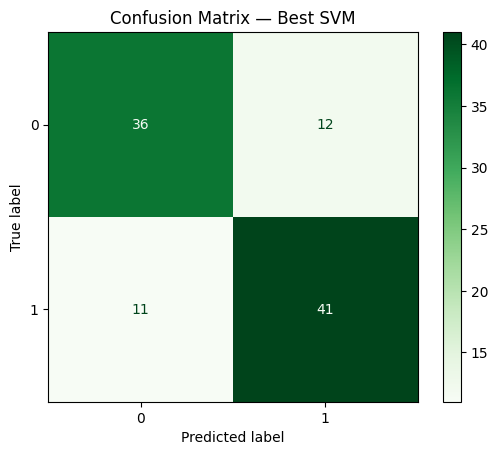


Detected number of classes: 2


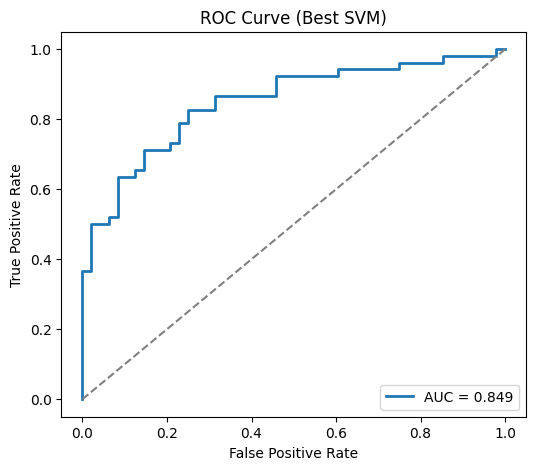

ROC AUC: 0.8490

--- Per-kernel small re-search to get best per-kernel ROC curves ---

Kernel: linear  best params: {'svc__C': 1, 'svc__kernel': 'linear'}  cv_score: 0.7275

Kernel: rbf  best params: {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}  cv_score: 0.7600

Kernel: poly  best params: {'svc__C': 1, 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}  cv_score: 0.7100

Kernel: sigmoid  best params: {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'sigmoid'}  cv_score: 0.7250


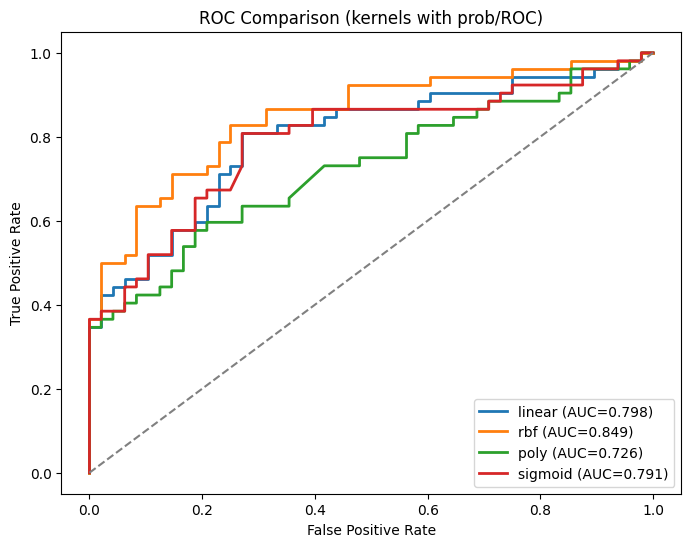


Per-kernel AUC summary:
linear AUC: 0.798477564102564
rbf AUC: 0.8489583333333334
poly AUC: 0.7255608974358975
sigmoid AUC: 0.7910657051282052

Plotting PCA decision regions (visualization only):


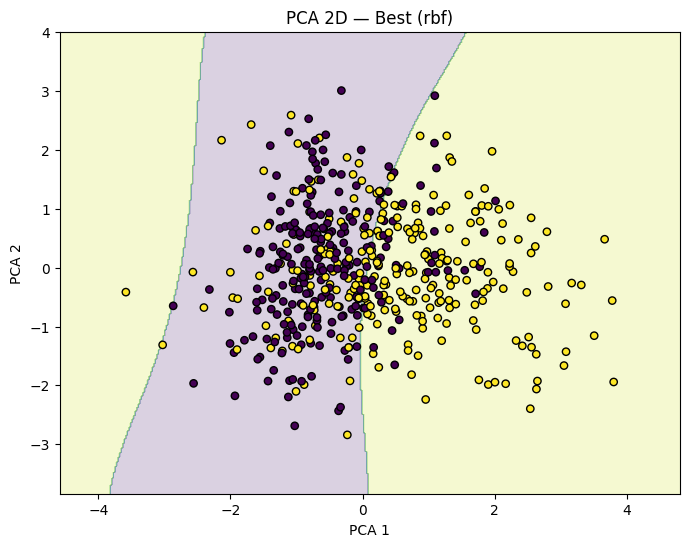

Plotting PCA for kernel linear (best params {'svc__C': 1, 'svc__kernel': 'linear'})


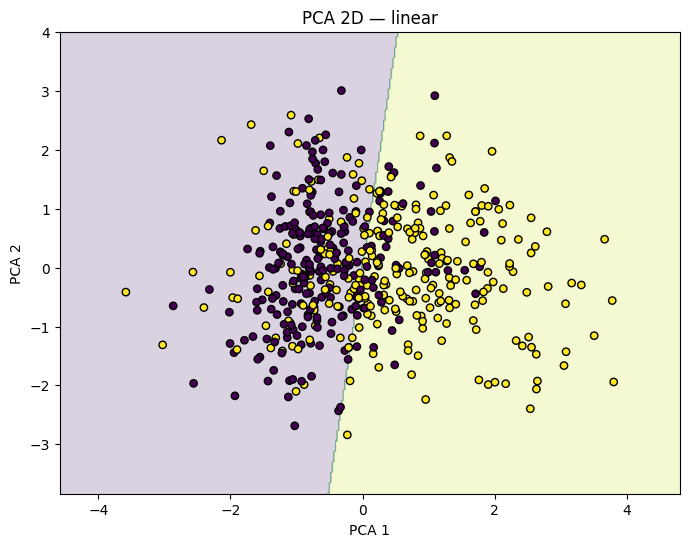

Plotting PCA for kernel rbf (best params {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'})


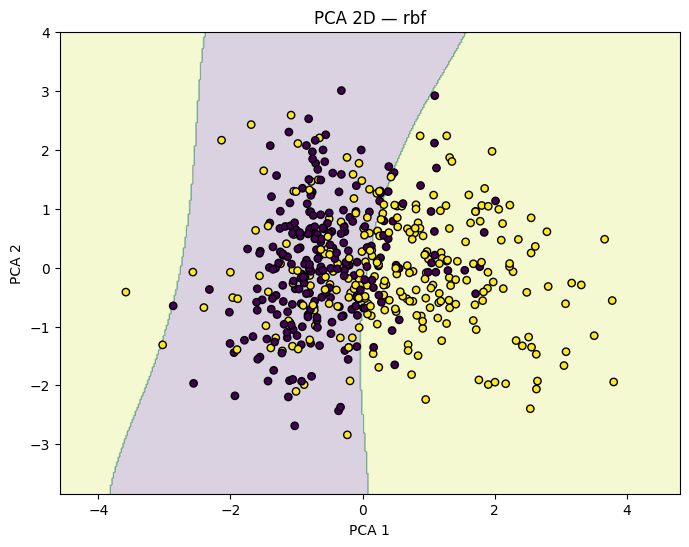

Plotting PCA for kernel poly (best params {'svc__C': 1, 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'poly'})


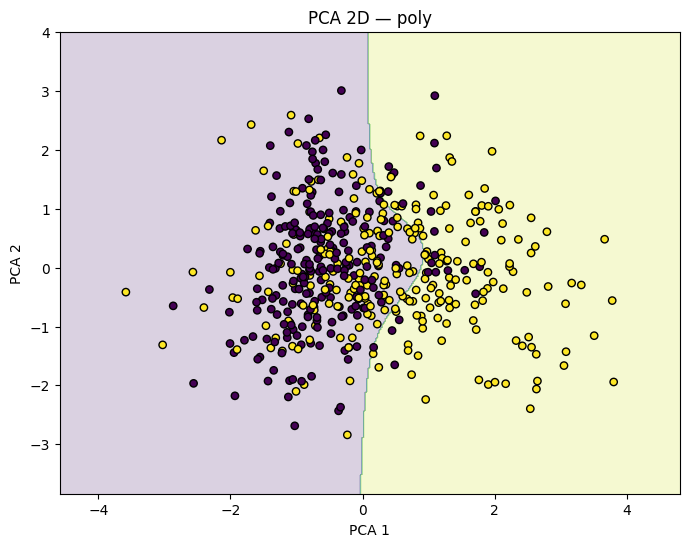

Plotting PCA for kernel sigmoid (best params {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'sigmoid'})


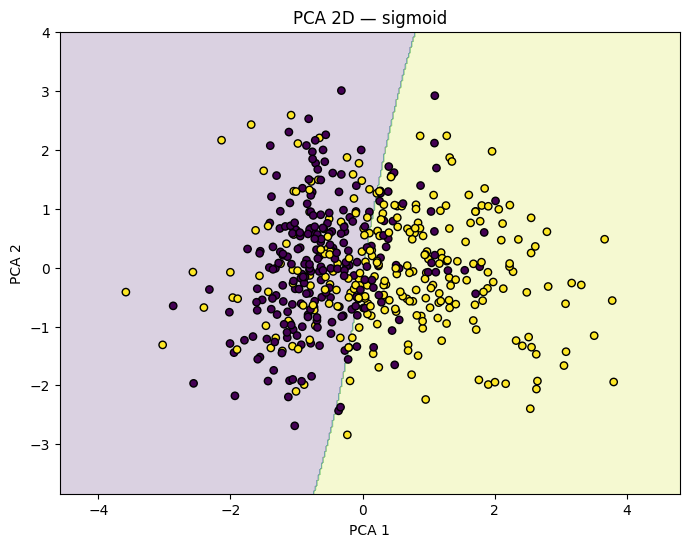


Saved best pipeline to model_best.joblib

Done — kernels explored (linear, poly, rbf, sigmoid). The best model is saved as model_best.joblib


In [2]:
#  SVM pipeline (linear , poly , rbf ,sigmoid)
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score
)
from sklearn.decomposition import PCA
import joblib

#  CONFIG
DATA_PATH = "Pharma_Industry.csv"   # change if needed
TARGET_COL = None                   # if you want to force a column, set its name here
RANDOM_STATE = 42
TEST_SIZE = 0.20
OUT_MODEL = "model_best.joblib"

#  Load
p = Path(DATA_PATH)
if not p.exists():
    raise FileNotFoundError(f"File not found at {DATA_PATH}. Upload the file or change DATA_PATH.")

df = pd.read_csv(p)
print("Loaded CSV. Shape:", df.shape)
print("Columns:", list(df.columns))

#  Auto-detect target (same as your helper)
def pick_target(df):
    candidates = []
    for col in df.columns:
        vals = df[col].dropna().unique()
        nunique = df[col].nunique(dropna=True)
        name_lower = col.lower()
        if any(tok in name_lower for tok in ("id","serial","srno","index","row")) and nunique > 0.5 * len(df):
            continue
        unique_set = set(vals)
        try:
            if unique_set.issubset({0,1}):
                candidates.append((col, "binary_0_1", nunique))
                continue
        except Exception:
            pass
        lower_vals = set(str(x).strip().lower() for x in vals if pd.notna(x))
        if lower_vals and lower_vals.issubset({"0","1","yes","no","true","false","y","n","positive","negative"}):
            candidates.append((col, "binary_str_like", nunique))
            continue
        if any(k in name_lower for k in ("response","target","label","outcome","status","class")):
            candidates.append((col, "name_hint", nunique))
            continue
    priority = ("binary_0_1","binary_str_like","name_hint")
    for pr in priority:
        for col, kind, nunique in candidates:
            if kind == pr:
                return col, kind
    col_nunique = [(c, df[c].nunique(dropna=True)) for c in df.columns]
    col_nunique = [x for x in col_nunique if 1 < x[1] < len(df)]
    col_nunique.sort(key=lambda x: x[1])
    if col_nunique:
        return col_nunique[0][0], "smallest_nunique_fallback"
    return df.columns[-1], "last_column_fallback"

if TARGET_COL is None:
    chosen, reason = pick_target(df)
    print(f"Auto-selected target column: '{chosen}' (reason: {reason})")
    TARGET_COL = chosen
else:
    print(f"Using user-specified TARGET_COL = '{TARGET_COL}'")

#  Initial target check & preprocessing
print("\nTarget value counts (before conversion):")
print(df[TARGET_COL].value_counts(dropna=False))

# Fill missing numeric/object values (keep your approach)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
obj_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if num_cols:
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

for c in obj_cols:
    if df[c].isna().any():
        mode = df[c].mode()
        fill = mode[0] if not mode.empty else "missing"
        df[c] = df[c].fillna(fill)

# One-hot encode non-target object columns
if TARGET_COL in obj_cols:
    obj_cols_for_encoding = [c for c in obj_cols if c != TARGET_COL]
else:
    obj_cols_for_encoding = obj_cols

if obj_cols_for_encoding:
    df = pd.get_dummies(df, columns=obj_cols_for_encoding, drop_first=True)
    print(f"\nOne-hot encoded columns: {obj_cols_for_encoding}")

# Normalize/convert target to numeric
if not pd.api.types.is_numeric_dtype(df[TARGET_COL]):
    mapping_yes = {"yes":1,"y":1,"true":1,"t":1,"positive":1,"pos":1}
    mapping_no  = {"no":0,"n":0,"false":0,"f":0,"negative":0,"neg":0}
    def map_target(x):
        s = str(x).strip().lower()
        if s in mapping_yes: return 1
        if s in mapping_no: return 0
        try:
            v = float(s)
            if v in (0.0, 1.0): return int(v)
            return int(v) if v.is_integer() else v
        except Exception:
            return s
    df[TARGET_COL] = df[TARGET_COL].apply(map_target)

if not pd.api.types.is_numeric_dtype(df[TARGET_COL]):
    df[TARGET_COL], uniques = pd.factorize(df[TARGET_COL])
    target_classes = list(uniques)
    print(f"\nFactorized target, mapping: {dict(enumerate(uniques))}")
else:
    target_classes = sorted(pd.unique(df[TARGET_COL]))

print("\nPost-processed target value counts:")
print(df[TARGET_COL].value_counts())

#  Build X, y
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int) if pd.api.types.is_integer_dtype(df[TARGET_COL]) else df[TARGET_COL]

print("\nFeatures shape:", X.shape, "Target shape:", y.shape)
print("\nTarget class balance (normalized):")
print(y.value_counts(normalize=True))

#  Train/test split
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
except Exception:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

#  Pipeline & scaling baked in
base_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=RANDOM_STATE, probability=True))   # probability=True for ROC/proba
])

#  kernel-specific param grids
param_grid = [
    {"svc__kernel": ["linear"],  "svc__C": [0.01, 0.1, 1, 10]},
    {"svc__kernel": ["rbf"],     "svc__C": [0.1, 1, 10], "svc__gamma": ["scale", 0.1, 0.01]},
    {"svc__kernel": ["poly"],    "svc__C": [0.1, 1, 10], "svc__degree": [2, 3], "svc__gamma": ["scale", 0.1]},
    {"svc__kernel": ["sigmoid"], "svc__C": [0.1, 1, 10], "svc__gamma": ["scale", 0.1]},
]

grid = GridSearchCV(base_pipe, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring="accuracy")
grid.fit(X_train, y_train)

best_pipeline = grid.best_estimator_
print("\n=== GridSearch Completed ===")
print("Best params:", grid.best_params_)
print("Best CV score (accuracy):", grid.best_score_)

#  Evaluate best model
y_pred = best_pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy (best): {acc:.4f}")
print("\nClassification Report (best):\n", classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Greens")
plt.title("Confusion Matrix — Best SVM")
plt.show()

#  ROC / AUC (binary or multiclass)
n_classes = len(np.unique(y))
print(f"\nDetected number of classes: {n_classes}")

has_proba = True
try:
    y_score = best_pipeline.predict_proba(X_test)   # shape (n_samples, n_classes)
except Exception:
    # fallback to decision_function -> convert to score arrays (works for binary)
    try:
        dec = best_pipeline.decision_function(X_test)
        if n_classes == 2:
            # decision_function gives shape (n_samples,) or (n_samples,1)
            if dec.ndim == 1:
                y_score = np.vstack([1 - 1/(1+np.exp(dec)), 1/(1+np.exp(dec))]).T
            else:
                # already two columns
                y_score = dec
        else:
            y_score = None
    except Exception:
        y_score = None
        has_proba = False

if y_score is None:
    print("Probability scores not available; ROC/AUC cannot be computed reliably.")
else:
    # Binary classification: show single ROC
    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
        plt.plot([0,1],[0,1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (Best SVM)')
        plt.legend(loc='lower right'); plt.show()
        print(f"ROC AUC: {roc_auc:.4f}")
    else:
        # multiclass: compute one-vs-rest (macro) AUC if possible
        try:
            auc_score = roc_auc_score(y_test, y_score, multi_class='ovr', average='macro')
            print(f"Multiclass ROC AUC (ovr, macro): {auc_score:.4f}")
        except Exception as e:
            print("Multiclass ROC AUC computation failed:", e)

#  Compare kernels individually and plot combined ROC
print("\n--- Per-kernel small re-search to get best per-kernel ROC curves ---")
kernel_templates = {
    "linear":  {"svc__kernel":["linear"], "svc__C":[0.01,0.1,1,10]},
    "rbf":     {"svc__kernel":["rbf"], "svc__C":[0.1,1,10], "svc__gamma":["scale",0.1,0.01]},
    "poly":    {"svc__kernel":["poly"], "svc__C":[0.1,1,10], "svc__degree":[2,3], "svc__gamma":["scale",0.1]},
    "sigmoid": {"svc__kernel":["sigmoid"], "svc__C":[0.1,1,10], "svc__gamma":["scale",0.1]},
}
roc_results = []
plt.figure(figsize=(8,6))
for k, params in kernel_templates.items():
    try:
        g = GridSearchCV(base_pipe, param_grid=[params], cv=4, n_jobs=-1, scoring="accuracy", verbose=0)
        g.fit(X_train, y_train)
        model_k = g.best_estimator_
        print(f"\nKernel: {k}  best params: {g.best_params_}  cv_score: {g.best_score_:.4f}")


        try:
            prob_k = model_k.predict_proba(X_test)
            if n_classes == 2:
                fpr_k, tpr_k, _ = roc_curve(y_test, prob_k[:,1])
                auc_k = auc(fpr_k, tpr_k)
                plt.plot(fpr_k, tpr_k, lw=2, label=f"{k} (AUC={auc_k:.3f})")
                roc_results.append((k, auc_k, fpr_k, tpr_k))
            else:
                # multiclass: compute macro AUC
                auc_k = roc_auc_score(y_test, prob_k, multi_class='ovr', average='macro')
                print(f"{k} multiclass AUC (ovr,micro): {auc_k:.4f}")
                # do not plot multiclass ROC curves on same 2D plot
                roc_results.append((k, auc_k, None, None))
        except Exception as e:
            print(f"Probabilities not available for kernel {k}: {e}")
    except Exception as e:
        print(f"Grid search failed for kernel {k}: {e}")

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Comparison (kernels with prob/ROC)")
plt.legend(loc='lower right'); plt.show()

print("\nPer-kernel AUC summary:")
for r in roc_results:
    print(r[0], "AUC:", r[1])

#  PCA decision region visualizations per kernel (for intuition only)
def plot_svm_pca_for_kernel(trained_pipe, X_df, y_arr, title):
    # PCA on original feature matrix (scaled inside)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_df)
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X2 = pca.fit_transform(X_scaled)

    svc = trained_pipe.named_steps["svc"]
    vis = SVC(kernel=svc.kernel, C=svc.C, gamma=getattr(svc, "gamma", "scale"),
              degree=getattr(svc, "degree", 3), random_state=RANDOM_STATE)
    vis.fit(X2, y_arr)

    x_min, x_max = X2[:,0].min()-1, X2[:,0].max()+1
    y_min, y_max = X2[:,1].min()-1, X2[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min,x_max,400), np.linspace(y_min,y_max,400))
    Z = vis.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.scatter(X2[:,0], X2[:,1], c=y_arr, edgecolor='k', s=28)
    plt.title(title); plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
    plt.show()

# Combine original X (not scaled by pipeline) for a fair PCA projection over whole data
X_all = pd.concat([X_train, X_test], axis=0)
y_all = np.hstack([y_train, y_test])

# Plot for pipeline and for per-kernel
print("\nPlotting PCA decision regions (visualization only):")
try:
    plot_svm_pca_for_kernel(best_pipeline, X_all, y_all, title=f"PCA 2D — Best ({grid.best_params_['svc__kernel']})")
except Exception as e:
    print("Failed to plot best pipeline PCA:", e)

for k, params in kernel_templates.items():
    try:
        g2 = GridSearchCV(base_pipe, param_grid=[params], cv=4, n_jobs=-1, scoring="accuracy", verbose=0)
        g2.fit(X_train, y_train)
        print(f"Plotting PCA for kernel {k} (best params {g2.best_params_})")
        plot_svm_pca_for_kernel(g2.best_estimator_, X_all, y_all, title=f"PCA 2D — {k}")
    except Exception as e:
        print(f"Skipping PCA for kernel {k} due to: {e}")

#  pipeline
artifact = {
    "pipeline": best_pipeline,
    "feature_names": list(X.columns),
    "target_classes": target_classes
}
joblib.dump(artifact, OUT_MODEL)
print(f"\nSaved best pipeline to {OUT_MODEL}")

print("\nDone — kernels explored (linear, poly, rbf, sigmoid). The best model is saved as", OUT_MODEL)


In [3]:
# Write app.py
app_code = r"""
import joblib
import pandas as pd
import numpy as np
from pathlib import Path
import streamlit as st
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

st.set_page_config(page_title='Drug Response Classifier', layout='centered')
st.title('Drug Response Classifier (SVM)')

MODEL_PATH = Path('model.joblib')
DATA_PATH = Path('Pharma_Industry.csv')  # only used to get feature ranges (optional)

if not MODEL_PATH.exists():
    st.error('model.joblib not found. Run the training notebook cell to create it.')
    st.stop()

artifact = joblib.load(MODEL_PATH)
pipe = artifact['pipeline']
feature_names = artifact['feature_names']
classes = artifact['target_classes']

# Build input UI from dataset stats if available
if DATA_PATH.exists():
    df = pd.read_csv(DATA_PATH)
    # keep only features we trained on
    df = df[feature_names]
else:
    st.warning('Pharma_Industry.csv not found — using default slider ranges.')
    df = pd.DataFrame(columns=feature_names)

st.sidebar.header('Input features')
stats = df.describe().T if not df.empty else None
user_vals = {}
for col in feature_names:
    if stats is not None and col in stats.index:
        cmin = float(stats.loc[col, 'min'])
        cmax = float(stats.loc[col, '75%'] * 1.5 if not np.isnan(stats.loc[col, '75%']) else stats.loc[col, 'max'])
        cval = float(stats.loc[col, 'mean'])
        step = max((cmax - cmin) / 100, 1e-3)
    else:
        cmin, cmax, cval, step = 0.0, 1.0, 0.5, 0.01
    user_vals[col] = st.sidebar.slider(col, min_value=cmin, max_value=cmax, value=cval, step=step)

if st.sidebar.button('Predict'):
    X_user = pd.DataFrame([user_vals])[feature_names]
    proba = pipe.predict_proba(X_user)
    pred_idx = int(np.argmax(proba, axis=1)[0])
    pred_prob = float(np.max(proba, axis=1)[0])
    pred_label = classes[pred_idx] if len(classes) > pred_idx else str(pred_idx)

    st.subheader('Prediction')
    st.metric('Predicted class', str(pred_label))
    st.metric('Confidence', f'{pred_prob:.3f}')

st.markdown('---')
st.caption('Model: StandardScaler + SVC (best kernel via GridSearchCV)')
"""
with open("app.py", "w", encoding="utf-8") as f:
    f.write(app_code)
print("Wrote app.py")

# Write requirements.txt
reqs = """streamlit
pandas
numpy
scikit-learn
joblib
matplotlib
"""
with open("requirements.txt", "w") as f:
    f.write(reqs)
print("Wrote requirements.txt")


Wrote app.py
Wrote requirements.txt


In [ ]:
!pip install -r requirements.txt
!streamlit run app.py


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 71.1 MB/s eta 0:00:00



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.139.211.34:8501

